In [1]:
from diffusers import AutoencoderKL

# Specify the directory containing the model files
model_directory = "../my_checkpoint_dir/stable-diffusion-2/vae/"  # Update this path to where your files are located

# Load the model
vae = AutoencoderKL.from_pretrained(model_directory)

# Now you can use the VAE for encoding and decoding images as described previously


/cluster/work/riner/users/cmazzoleni/Marigold/venv/multi_diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.112221956..1.0749519].


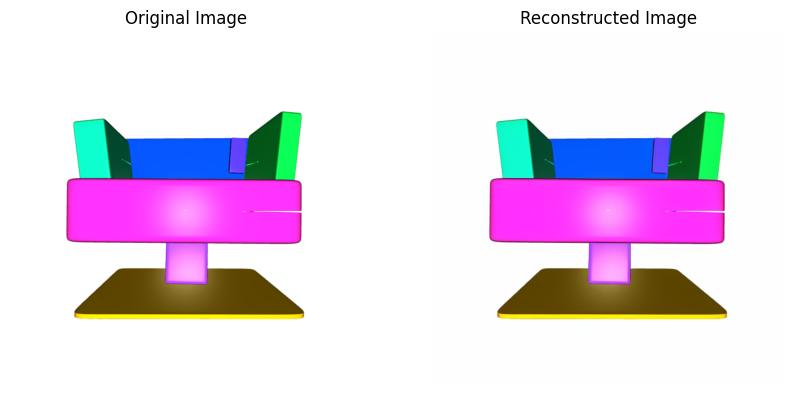

In [3]:

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import pil_to_tensor
from diffusers import AutoencoderKL
from typing import Union
vae.eval()

# The provided encode_image function
def preprocess_image(input_image: Union[Image.Image, torch.Tensor]):
    """
    Encodes an image to its latent representation using the MarigoldPipeline.

    Args:
        pipeline (MarigoldPipeline): The MarigoldPipeline instance.
        input_image (Union[Image.Image, torch.Tensor]): The input image to encode.

    Returns:
        torch.Tensor: The latent representation of the image.
    """
    if isinstance(input_image, Image.Image):
        input_image = input_image.convert("RGB")
        #resize to 600x600
        input_image = input_image.resize((600, 600))
        rgb = pil_to_tensor(input_image)
        rgb = rgb.unsqueeze(0)  # [1, rgb, H, W]
    elif isinstance(input_image, torch.Tensor):
        rgb = input_image
    else:
        raise TypeError(f"Unknown input type: {type(input_image) = }")
    
    rgb_norm = rgb / 255.0 * 2.0 - 1.0  # [0, 255] -> [-1, 1]
    return rgb_norm

def encode_decode_image(image, model):
    with torch.no_grad():
        encoded = model.encode(image).latent_dist.sample()  # Encode to latent representation
        decoded = model.decode(encoded).sample  # Decode back to image
    return decoded


# Visualize the original and reconstructed images
def visualize_reconstruction(original, reconstructed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original image
    axs[0].imshow(np.transpose(original.squeeze().cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    # Reconstructed image
    axs[1].imshow(np.transpose(reconstructed.squeeze().cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
    axs[1].set_title('Reconstructed Image')
    axs[1].axis('off')
    
    plt.show()

# Example usage
#input_image = Image.open("/Users/cmazzoleni/Documents/GitHub/PrimitiveDifformation/Marigold/input/in-the-wild_example/example_5_pred_colored.png")
input_image = Image.open("/cluster/work/riner/users/cmazzoleni/dataset_depth_map/chair/1ad766f9e95ce308aa425ecb668e59de_complete_object.png")
pipeline = vae  # Assuming 'vae' is your model

input_image = preprocess_image(input_image)

# Decode the latent representation to get the reconstructed image
reconstructed_image = encode_decode_image(input_image, vae)

# Visualize the original and reconstructed images
visualize_reconstruction(input_image, reconstructed_image)